In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import numpy as np
import time
now = time.strftime('%d%m%Y%H%M%S')

In [3]:
#import raw csv from github from johns hopkins u github
cor = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [4]:
# extract 'country/region' column
cor_cr = cor['Country/Region']
#drop columns
df_cor = cor.drop(['Lat', 'Long', 'Country/Region'], axis=1)
#insert 'country/region' in pos[0]
df_cor.insert(0, 'Country/Region', cor_cr)

In [5]:
df_usa = df_cor[df_cor['Country/Region'] == 'US']
df_usa.head()

,Country/Region,Province/State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
98,US,Washington,0,0,0,0,0,0,0,0,...,442,568,572,643,904,1076,1014,1376,1524,1793
99,US,New York,0,0,0,0,0,0,0,0,...,328,421,525,732,967,1706,2495,5365,8310,11710
100,US,California,0,0,0,0,0,0,0,0,...,221,282,340,426,557,698,751,952,1177,1364
101,US,Massachusetts,0,0,0,0,0,0,0,0,...,108,123,138,164,197,218,218,328,413,525
102,US,Diamond Princess,0,0,0,0,0,0,0,0,...,46,46,46,46,47,47,47,47,49,49


In [6]:
### Melt the dateframe into the right shape and set index
# from Mohammad Ashbad blog on towardsdatascience
# https://towardsdatascience.com/analyzing-coronavirus-covid-19-data-using-pandas-and-plotly-2e34fe2c4edc

def cleandata(df_raw):

    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region'],value_name='Cases',var_name='Date')

    df_cleaned=df_cleaned.set_index(['Date'])

    return df_cleaned 

In [7]:
# from Mohammad Ashbad blog on towardsdatascience
# https://towardsdatascience.com/analyzing-coronavirus-covid-19-data-using-pandas-and-plotly-2e34fe2c4edc

def countrydata(df_cleaned,oldname,newname):

    df_country=df_cleaned.groupby(['Country/Region','Date'])['Cases'].sum().reset_index()

    df_country=df_country.set_index(['Date'])

    df_country.index= pd.to_datetime(df_country.index)

    df_country=df_country.sort_values(['Country/Region','Date'],ascending=True)

    df_country=df_country.rename(columns={oldname:newname})

    return df_country


### Get DailyData from Cumulative sum

def dailydata(dfcountry,oldname,newname):

   #dfcountrydaily=dfcountry.groupby(level=0).diff().fillna(0)

    dfcountrydaily=dfcountry.rename(columns={oldname:newname})

    return dfcountrydaily

In [8]:
# clean data
df_usa_v = cleandata(df_usa)
df_usa_v = df_usa_v.drop(columns='Province/State')
df_usa_v.head()

,Country/Region,Cases
Date,,
1/22/20,US,0
1/22/20,US,0
1/22/20,US,0
1/22/20,US,0
1/22/20,US,0


In [9]:
# clean and align data
df_usa_data = countrydata(df_usa_v, 'Cases', 'Total Cases')
df_usa_data = dailydata(df_usa_data, 'Total Cases', 'Daily Total Cases')
df_usa_data['Daily New Cases'] = df_usa_data['Daily Total Cases'].diff().fillna(0)
df_usa_data = df_usa_data.drop(['Country/Region', 'Daily New Cases'], axis=1)
df_usa_data.to_csv('df_usa_data'+now+'.csv')
df_usa_data.head()

,Daily Total Cases
Date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


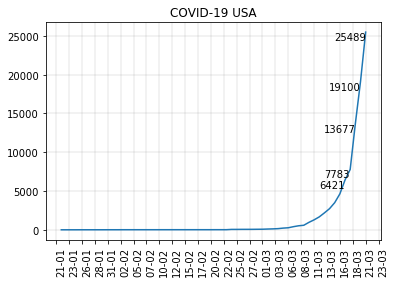

In [10]:
#plot USA counts
usa_dates = df_usa_data.index.values
usa_counts = df_usa_data['Daily Total Cases']
fig, ax = plt.subplots()  # Create a figure containing a single axes.

xfmt = mdates.DateFormatter('%d-%m')
ax.xaxis.set_major_formatter(xfmt)

locator = MaxNLocator(nbins=30) # with 14 bins you will have 13 ticks
ax.xaxis.set_major_locator(locator)

plt.xticks(rotation=90, va='top', ha='left', fontsize=10)
ax.grid(color='grey', linestyle='-', linewidth=0.2)
ax.plot(usa_dates, usa_counts)  # Plot some data on the axes.
ax.annotate(str(usa_counts[-1]),xy=(usa_dates[-1],usa_counts[-1]), horizontalalignment='right', verticalalignment='top', clip_on=True)
ax.annotate(str(usa_counts[-2]),xy=(usa_dates[-2],usa_counts[-2]), horizontalalignment='right', verticalalignment='top')
ax.annotate(str(usa_counts[-3]),xy=(usa_dates[-3],usa_counts[-3]), horizontalalignment='right', verticalalignment='top')
ax.annotate(str(usa_counts[-4]),xy=(usa_dates[-4],usa_counts[-4]), horizontalalignment='right', verticalalignment='top')
ax.annotate(str(usa_counts[-5]),xy=(usa_dates[-5],usa_counts[-5]), horizontalalignment='right', verticalalignment='top')

plt.title('COVID-19 USA')
#plt.legend(loc='upper center')
plt.savefig('USA_covid-19'+now+'.png')
plt.show()

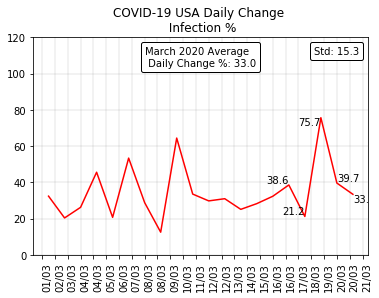

In [14]:
# plot USA rate of daily change from March 2020
usa_dates = df_usa_data.index.values[39:]  #[4:-1]
usa_counts = df_usa_data['Daily Total Cases'][39:]  #[4:-1]
usa_change = usa_counts.pct_change(fill_method='ffill')*100
usa_perc = round(usa_change, 1)
usa_perc_ave = round(usa_change.sum() / len(usa_change),1)
usa_std = round(usa_change.std(),1)


fig, ax = plt.subplots()  # Create a figure containing a single axes.

#xfmt = mdates.DateFormatter('%d/%m/%y')
xfmt = mdates.DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(xfmt)

locator = MaxNLocator(nbins=30) # with 14 bins you will have 13 ticks
ax.xaxis.set_major_locator(locator)

plt.xticks(rotation=90, va='top', ha='left', fontsize=10)
ax.grid(color='grey', linestyle='-', linewidth=0.2)
ax.plot(usa_dates, usa_change, color='red')  # Plot some data on the axes.

ax.annotate(str(usa_perc[-1]),xy=(usa_dates[-1],usa_perc[-1]), horizontalalignment='left', verticalalignment='top', clip_on=True)
ax.annotate(str(usa_perc[-2]),xy=(usa_dates[-2],usa_perc[-2]), horizontalalignment='left', verticalalignment='bottom', clip_on=True)
ax.annotate(str(usa_perc[-3]),xy=(usa_dates[-3],usa_perc[-3]), horizontalalignment='right', verticalalignment='top', clip_on=True)
ax.annotate(str(usa_perc[-4]),xy=(usa_dates[-4],usa_perc[-4]), horizontalalignment='right', verticalalignment='bottom', clip_on=True)
ax.annotate(str(usa_perc[-5]),xy=(usa_dates[-5],usa_perc[-5]), horizontalalignment='right', verticalalignment='bottom', clip_on=True)
from matplotlib.offsetbox import AnchoredText
at = AnchoredText('March 2020 Average \n Daily Change %: ' + str(usa_perc_ave),
                  prop=dict(size=10), frameon=True,
                  loc='upper center',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

at = AnchoredText('Std: ' + str(usa_std),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


plt.ylim(0, 120)
plt.title('COVID-19 USA Daily Change \n Infection %')
#plt.legend(loc='upper center')
plt.savefig('usa_covid-19_change'+now+'.png')
plt.show()